# Завдання
* Зтворіть дві моделі - RNN та LSTM та порівняйте результати
* Додатково: як кількість кроків, на яку ми прогнозуємо, впливає на результат?

# Виконання

In [82]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [83]:
data = pd.read_csv('data/sales_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)
data.index.name = 'Datetime'

print(f'Dataset size = {len(data)}')
print(data.head())

Dataset size = 72
            values
Datetime          
2015-01-01      30
2015-02-01      21
2015-03-01      29
2015-04-01      31
2015-05-01      40


<Axes: xlabel='Datetime'>

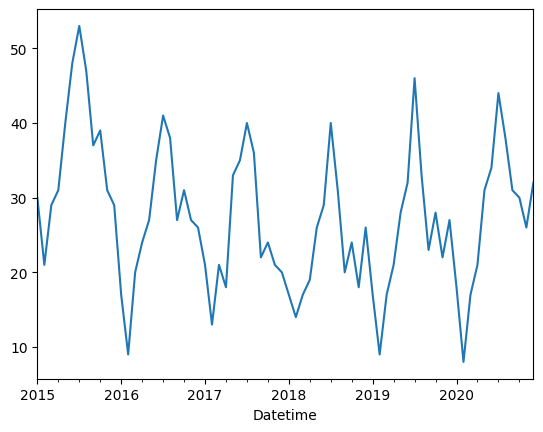

In [84]:
data['values'].plot()

In [85]:
test_set_size = 15
input_sliding_window_size = 3
output_sliding_window_size = 1

current_rnn_type = 'RNN'  # 'RNN', 'LSTM'
current_activation_function = nn.ReLU()

rnn_architectures = [
    [50],        
    [2, 64, 1],           
    [2, 64, 32, 1],       
    [2, 128, 64, 32, 1],  
    [2, 32, 32, 32, 1],   
]

current_criterion = nn.MSELoss()

In [86]:
def create_sliding_windows(input_data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(input_data) - lookback - forecast_horizon + 1):
        window_x = input_data[i:i + lookback].reshape(lookback, 1)
        window_y = input_data[i + lookback:i + lookback + forecast_horizon]
        X.append(window_x)
        y.append(window_y)
    return np.array(X), np.array(y)


def split_data(input_data_x, input_data_y, test_data_size):
    train_data_x = input_data_x[:-test_data_size]
    train_data_y = input_data_y[:-test_data_size]
    test_data_x = input_data_x[-test_data_size:]
    test_data_y = input_data_y[-test_data_size:]
    return train_data_x, train_data_y, test_data_x, test_data_y


scaler = MinMaxScaler()  # StandardScaler()
scaled_values = scaler.fit_transform(data.values.reshape(-1, 1))

dataset_x, dataset_y = create_sliding_windows(scaled_values, input_sliding_window_size, output_sliding_window_size)
print('Total windows count =', len(dataset_x))

train_x, train_y, test_x, test_y = split_data(dataset_x, dataset_y, test_set_size)
print('Train size: X =', len(train_x), ' Y =', len(train_y))
print('Test size: X =', len(test_x), ' Y =', len(test_y))

Total windows count = 69
Train size: X = 54  Y = 54
Test size: X = 15  Y = 15


In [87]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(train_x, train_y)
test_dataset  = TimeSeriesDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1,  shuffle=False)

In [88]:
class FlexibleRNN(nn.Module):
    def __init__(self, rnn_type, activation_function, sliding_window_size, forecast_horizon, layer_sizes):
        super(FlexibleRNN, self).__init__()
        self.hidden_size = layer_sizes[1]
        self.num_layers = len(layer_sizes) - 2

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=1, 
                hidden_size=self.hidden_size, 
                num_layers=self.num_layers,
                batch_first=True
            )
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=1,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True
            )
        else:
            raise ValueError("Invalid rnn_type. Choose from 'RNN' or 'LSTM'.")

        layers = []
        for i in range(1, len(layer_sizes) - 1):
            in_size = layer_sizes[i]
            out_size = layer_sizes[i+1] if (i+1 < len(layer_sizes) - 1) else forecast_horizon
            layers.append(nn.Linear(in_size, out_size))
            if i < len(layer_sizes) - 2:
                layers.append(activation_function)
                
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        if isinstance(self.rnn, nn.LSTM):
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            rnn_out, _ = self.rnn(x, (h_0, c_0))
        else:
            rnn_out, _ = self.rnn(x, h_0)

        out = self.fc(rnn_out[:, -1, :])
        return out

In [89]:
def train_model(model, criterion, train_loader, num_epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}")

    return train_losses

Created model:
FlexibleRNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [50/200] - Train Loss: 0.0201
Epoch [100/200] - Train Loss: 0.0252
Epoch [150/200] - Train Loss: 0.0234
Epoch [200/200] - Train Loss: 0.0177


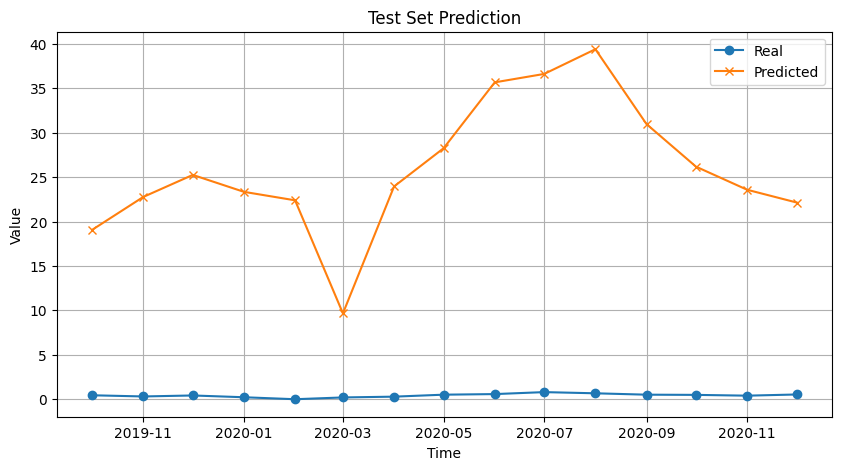

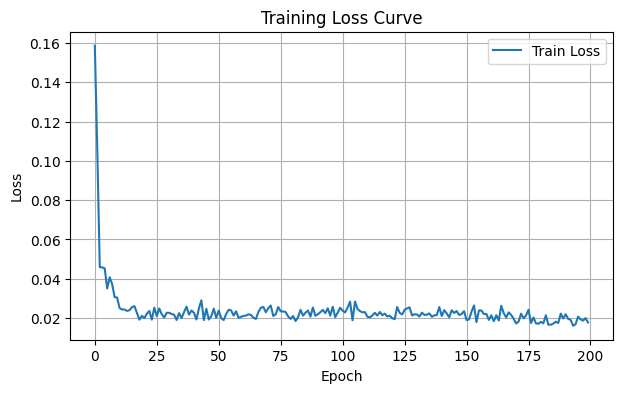

In [90]:
chosen_arch = rnn_architectures[1]
model = FlexibleRNN(
    rnn_type=current_rnn_type,
    activation_function=current_activation_function,
    sliding_window_size=input_sliding_window_size,
    forecast_horizon=output_sliding_window_size,
    layer_sizes=chosen_arch
)

print("Created model:")
print(model)

train_losses = train_model(
    model=model,
    criterion=current_criterion,
    train_loader=train_loader,
    num_epochs=200,
    lr=0.01
)


model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_pred = model(batch_x)
        predictions.append(y_pred.squeeze().item())
        actuals.append(batch_y.squeeze().item())

predictions = np.array(predictions)
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1,1)).ravel()
actuals = np.array(actuals)


test_index = data.index[-test_set_size:]

plt.figure(figsize=(10,5))
plt.plot(test_index, actuals, label='Real', marker='o')
plt.plot(test_index, predictions_original_scale, label='Predicted', marker='x')
plt.title("Test Set Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()